In [1]:
import sys; sys.path.append('..')

In [2]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext import data
from torchtext.data import Field, Dataset, Example
from firelab import BaseTrainer
from firelab.utils import cudable

from src.losses import compute_bleu_for_sents
from src.utils.common import itos_many
from src.models.utils import inference

In [3]:
data_path = '../data/quora/quora.tok.bpe'
batch_size = 32
with open(data_path) as f: lines = f.read().splitlines()

text = Field(init_token='<bos>', eos_token='<eos>', batch_first=True)

examples = [Example.fromlist([s], [('text', text)]) for s in lines]
dataset = Dataset(examples, [('text', text)])
# TODO: torchtext is insane. We pass split ratio for [train, val, test]
# and it returns splits for [train, test, val]
splits = dataset.split(split_ratio=[0.999, 0.0009, 0.0001])
train_ds, test_ds, val_ds = splits
text.build_vocab(train_ds)

vocab = text.vocab
train_dataloader = data.BucketIterator(train_ds, batch_size, repeat=False)
val_dataloader = data.BucketIterator(val_ds, batch_size, train=False, sort=False)
test_dataloader = data.BucketIterator(test_ds, batch_size, train=False, sort=False)

In [4]:
class LSTMEncoder(nn.Module):
    def __init__(self, emb_size, hid_size, vocab_size):
        super(LSTMEncoder, self).__init__()

        self.hid_size = hid_size
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hid_size, batch_first=True)
        
        self.hid_to_z = nn.Sequential(
            nn.Linear(hid_size, 256),
            nn.SELU(),
            nn.Linear(256, hid_size)
        )

    def forward(self, sentence):
        embs = self.embeddings(sentence)
        _, last_hidden_state = self.gru(embs)
        z = self.hid_to_z(last_hidden_state.squeeze(0)).unsqueeze(0)

        return z

class LSTMDecoder(nn.Module):
    def __init__(self, emb_size, hid_size, vocab_size):
        super(LSTMDecoder, self).__init__()

        self.hid_size = hid_size
        self.z_to_state = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.SELU()
        )
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hid_size, batch_first=True)
        self.embs_to_logits = nn.Linear(hid_size, vocab_size)
        #self.embs_to_logits.weight = self.embeddings.weight # Sharing weights

    def forward(self, z, sentences):
        z = self.z_to_state(z.squeeze(0)).unsqueeze(0)
        embs = self.embeddings(sentences)
        hidden_states, _ = self.gru(embs, z)
        logits = self.embs_to_logits(hidden_states)

        return logits

In [5]:
emb_size = 1024
hid_size = 1024

weights = cudable(torch.ones(len(vocab)))
weights[vocab.stoi['<pad>']] = 0

rec_criterion = nn.CrossEntropyLoss(weights, size_average=True)
encoder = cudable(LSTMEncoder(emb_size, hid_size, len(vocab)))
decoder = cudable(LSTMDecoder(emb_size, hid_size, len(vocab)))

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = Adam(parameters, lr=1e-4, betas=(0.5, 0.98))

No handles with labels found to put in legend.


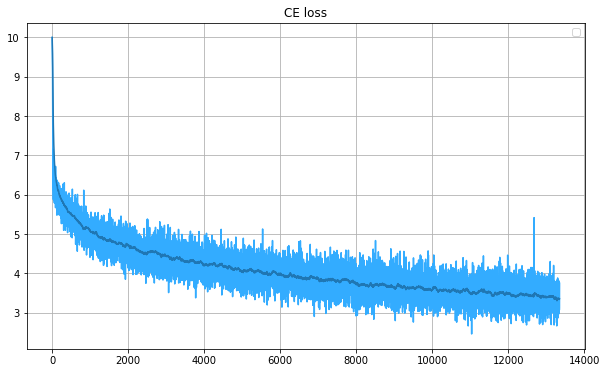

KeyboardInterrupt: 

In [6]:
% matplotlib inline

from tqdm import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

loss_history = []
num_iters_done = 0

for batch in train_dataloader:
    batch.text = cudable(batch.text)
    inputs, trg = batch.text[:, :-1], batch.text[:, 1:]
    encodings = encoder(batch.text)
    recs = decoder(encodings, inputs)

    loss = rec_criterion(recs.view(-1, len(vocab)), trg.contiguous().view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if num_iters_done % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[10,6])
        plt.title("CE loss")
        plt.plot(loss_history, color='#33ACFF')
        plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean())

        plt.grid()
        plt.legend()
        plt.show()
    
    num_iters_done += 1

In [ ]:
def inference(model, z, vocab, max_len=100):
    """
    All decoder models have the same inference procedure
    Let's move it into the common function
    """
    batch_size = z.size(0)
    BOS, EOS = vocab.stoi['<bos>'], vocab.stoi['<eos>']
    active_seqs = cudable(torch.tensor([[BOS] for _ in range(batch_size)]).long())
    active_seqs_idx = np.arange(batch_size)
    finished = [None for _ in range(batch_size)]
    n_finished = 0

    for _ in range(max_len):
        next_tokens = model.forward(z.unsqueeze(0), active_seqs).max(dim=-1)[1][:,-1] # TODO: use beam search
        active_seqs = torch.cat((active_seqs, next_tokens.unsqueeze(1)), dim=-1)
        finished_mask = (next_tokens == EOS).cpu().numpy().astype(bool)
        finished_seqs_idx = active_seqs_idx[finished_mask]
        active_seqs_idx = active_seqs_idx[finished_mask == 0]
        n_finished += finished_seqs_idx.size

        if finished_seqs_idx.size != 0:
            # TODO(universome)
            # finished[finished_seqs_idx] = active_seqs.masked_select(next_tokens == EOS).cpu().numpy()
            for i, seq in zip(finished_seqs_idx, active_seqs[next_tokens == EOS]):
                finished[i] = seq.cpu().numpy().tolist()

            active_seqs = active_seqs[next_tokens != EOS]
            z = z[next_tokens != EOS]

        if n_finished == batch_size: break

    # Well, some sentences were finished at the time
    # Let's just fill them in
    if n_finished != batch_size:
        # TODO(universome): finished[active_seqs_idx] = active_seqs
        for i, seq in zip(active_seqs_idx, active_seqs):
            finished[i] = seq.cpu().numpy().tolist()

    return finished

In [ ]:
scores = []

for batch in val_dataloader:
    encodings = encoder(batch.text)
    predictions = inference(decoder, encodings.squeeze(0), vocab)
    originals = itos_many(batch.text.cpu().numpy().tolist(), vocab)
    predictions = itos_many(predictions, vocab)

    score = compute_bleu_for_sents(predictions, originals)
    
    scores.append(score)

np.mean(scores)